Distribution of Bednights found to potentially be bimodal when a histogram was plotted. It appears that one group of residents stayed for a median of about 362 while another group stayed of about 950 days.

Goal: split clients automatically into different groups for each mode. use the sorted targets to train a model to predict "unknown" targets.

In [4]:
##Import Modules
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
##Load data. Known to be complete without duplicates. create dummies
reg = pd.read_csv('C:/Users/morel/Downloads/Training Data 7-28-2025.csv')
reg = pd.get_dummies(reg, columns=['RegionCode','Destination','HHSize'], dtype=int)
print(reg.head())

   FamilyID  ResidentID  Bednights  HHEmployed  HHTANF  Slotted  SlottedCCM  \
0       243         957        957           1       0        0           0   
1       243         958        957           1       0        0           0   
2       243         959        957           1       0        0           0   
3       243         960        957           1       0        0           0   
4       242         973        944           1       0        1           1   

   SlottedPME  SingleMom  SingleDad  ...  Destination_10  Destination_11  \
0           0          1          0  ...               0               0   
1           0          1          0  ...               0               0   
2           0          1          0  ...               0               0   
3           0          1          0  ...               0               0   
4           0          0          0  ...               0               0   

   HHSize_2  HHSize_3  HHSize_4  HHSize_5  HHSize_6  HHSize_7  HHSiz

In [6]:
##Assign each individual to a mode, first aggregate mean family bednights to avoid autocorrelation
group_target = reg.groupby('FamilyID')['Bednights'].mean()

In [8]:
##Assign each individual to a mode, assign each family average to a mode
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(group_target.values.reshape(-1,1))

GaussianMixture(n_components=2, random_state=42)

In [10]:
##Assign each individual to a mode, map modes back to individuals
group_modes = dict(zip(group_target.index, gmm.predict(group_target.values.reshape(-1,1))))
y_modes = reg['FamilyID'].map(group_modes).values

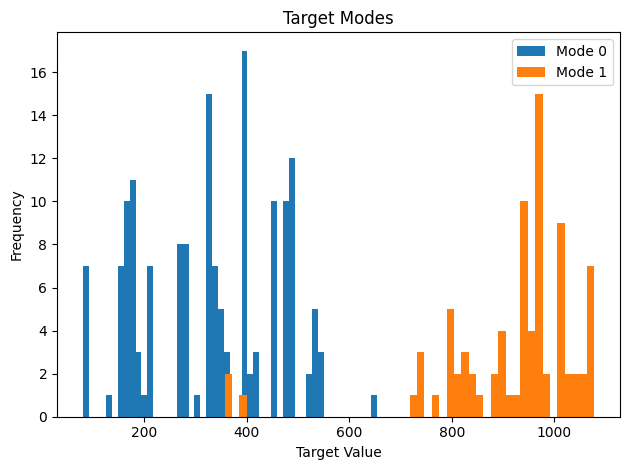

<Figure size 640x480 with 0 Axes>

In [11]:
##Assign each individual to a mode, plot histogram of targets with mode assignments.
plt.hist(reg['Bednights'][y_modes == 0], bins=50, label='Mode 0')
plt.hist(reg['Bednights'][y_modes == 1], bins=50, label='Mode 1')
plt.legend()
plt.title('Target Modes')
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
plt.clf()

In [19]:
##Train a model to assign to a target mode based on input features.
x = reg.drop(columns=['Bednights','FamilyID','ResidentID'])
groups = reg['FamilyID']

gkf = GroupKFold(n_splits=5)
clf = RandomForestClassifier(random_state=42)

accuracies = []
auc_scores = []

for train_idx, test_idx in gkf.split(x, y_modes, groups=groups):
    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y_modes.iloc[train_idx], y_modes.iloc[test_idx]

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    y_proba = clf.predict_proba(x_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    accuracies.append(acc)
    auc_scores.append(auc)

print(f'Mean Accuracy: {np.mean(accuracies):.3f}, Mean ROC AUC: {np.mean(auc_scores):.3f}')

Mean Accuracy: 0.627, Mean ROC AUC: 0.639
